# Import Statements

In [1]:
import logging
logging.basicConfig(level=logging.INFO)
import warnings
warnings.filterwarnings('ignore')
import os

import geodata
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#packages that requires users to install externally
import pickle
import pyproj
from pyproj import Proj
from functools import partial
from shapely.geometry import shape, Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union
from shapely.ops import transform as transform
import statsmodels.api as sm
import cartopy.io.shapereader as shpreader

import geopandas as gpd
import geoplot
import seaborn as sns
import plotly.graph_objects as go

# Load from pickle

In [2]:
os.chdir('../data/pickle')

# state shapes
file = open("states.pickle",'rb')
states = pickle.load(file)
file.close()
# grid state shapes
file = open("grid_states.pickle",'rb')
grid_states = pickle.load(file)
file.close()
# includes LCOE
file = open("xarray_ds_wind.pickle",'rb')
xarray_ds_wind = pickle.load(file)
file.close()
file = open("xarray_ds_solar.pickle",'rb')
xarray_ds_solar = pickle.load(file)
file.close()
# renewable energy targets
# TERI
file = open("wind_t_30.pickle",'rb')
wind_t_30 = pickle.load(file)
file.close()
file = open("solar_t_30.pickle",'rb')
solar_t_30 = pickle.load(file)
file.close()
# NREL
file = open("wind_t_47.pickle",'rb')
wind_t_47 = pickle.load(file)
file.close()
file = open("solar_t_47.pickle",'rb')
solar_t_47 = pickle.load(file)
file.close()
file = open("grid_wind_t_30.pickle",'rb')
grid_wind_t_30 = pickle.load(file)
file.close()
file = open("grid_solar_t_30.pickle",'rb')
grid_solar_t_30 = pickle.load(file)
file.close()
# NREL
file = open("grid_wind_t_47.pickle",'rb')
grid_wind_t_47 = pickle.load(file)
file.close()
file = open("grid_solar_t_47.pickle",'rb')
grid_solar_t_47 = pickle.load(file)
file.close()
#Legends
file = open("grid_legend.pickle",'rb')
grid_legend = pickle.load(file)
file.close()
file = open("state_legend.pickle",'rb')
state_legend = pickle.load(file)
file.close()
#combined with cutout
# file = open("combine_solar_coal.pickle",'rb')
# combine_solar_coal = pickle.load(file)
# file.close()
# file = open("combine_wind_coal.pickle",'rb')
# combine_wind_coal = pickle.load(file)
# file.close()

# Download India 2018 ERA5 Hourly Weather Data

In [3]:
DS_hourly = geodata.Dataset(module="era5",
                            weather_data_config = "wind_solar_hourly",
                            bounds=[37, 68, 6, 98],
                            years=slice(2018, 2018),
                            months=slice(1,12))

if DS_hourly.prepared == False:
	DS_hourly.get_data()

INFO:geodata.dataset:Directory C:/Users/arjun/desktop/davidson_lab/data/era5 found, checking for completeness.
INFO:geodata.dataset:Directory complete.


# Create Cutout

In [4]:
## CUTOUT
cutout = geodata.Cutout(name = "india-2018-era5-wind-solar-hourly",
                        module = "era5",
                        weather_data_config = "wind_solar_hourly",
                        xs = slice(68, 98),
                        ys = slice(6, 37),
                        years=slice(2018, 2018),
                        months=slice(1,12))

cutout.prepare()

INFO:geodata.cutout:All cutout (india-2018-era5-wind-solar-hourly, C:/Users/arjun/desktop/davidson_lab/data/cutouts) files available.
INFO:geodata.cutout:Cutout subset prepared: <Cutout india-2018-era5-wind-solar-hourly x=68.00-98.00 y=37.00-6.00 time=2018/1-2018/12 prepared>
INFO:geodata.preparation:The cutout is already prepared. If you want to recalculate it, supply an `overwrite=True` argument.


True

# Import Coal Plant / Mine Data

### Importing data from Global Coal Plant Tracker

In [5]:
os.chdir('../tables')

In [6]:
plants = pd.read_csv("Global-Coal-Plant-Tracker-Jan-2022.csv", encoding="ISO-8859-1")
plants = plants[plants['Country'] == 'India']
plants = plants[plants['Latitude'].isna() == False]
plants = plants[plants['Longitude'].isna() == False]
plants = plants[plants['Status'].isin(['operating'])] 
# 'announced', 'cancelled', 'construction', 'permitted', 'pre-permit', 'retired', 'shelved'])]
plants = plants.drop_duplicates('ParentID')
plants = plants[['Plant', 'Subnational unit (province, state)', 'Status', 'Latitude', 'Longitude', 
                 'Capacity (MW)', 'Annual CO2 (million tonnes / annum)', 'Year']]
plants = plants.rename(columns={'Subnational unit (province, state)': 'State', 'Year': 'Plant Age'})
plants['Capacity (MW)'] = plants['Capacity (MW)'].astype(float)
plants['Plant Age'] = plants['Plant Age'].apply(lambda x: 2021 - float(x))
plants.head()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Plant           State     Status   Latitude  \
508       Balaji Cement power station  Andhra Pradesh  operating  16.283333   
509              Bander power station  Andhra Pradesh  operating  14.351195   
511           Bhadradri power station       Telangana  operating  18.027488   
515   Dr Narla Tata Rao power station  Andhra Pradesh  operating  16.598490   
522  East Godavari Mill power station  Andhra Pradesh  operating  17.300117   

     Longitude  Capacity (MW)  Annual CO2 (million tonnes / annum)  Plant Age  
508  81.216667           35.0                                  0.2       12.0  
509  80.143086          660.0                                  2.5        6.0  
511  80.735645          270.0                                  1.3        1.0  
515  80.536585          210.0                                  1.2       42.0  
522  82.614386           34.0                                  0.2       15.0

### Importing data from Pai Coal Mine Tracker

In [7]:
mines = pd.read_csv("pai_coal_mines.csv", encoding="ISO-8859-1")
mines.columns = ['MineID', 'State', 'District', 'Name',
                 'Coal/ Lignite Production (MT) (2019-2020)', 'Owner', 
                 'Coal/Lignite', 'Govt Owned/Private', 'Type', 
                 'Latitude', 'Longitude', 'Source', 'Accuracy', 
                 'Unnamed']
# mines = mines[mines['Country'] == 'India']
# mines = mines[mines['Status'] == 'Operating'] # 'Proposed'
mines = mines[mines['Latitude'].isna() == False]
mines = mines[mines['Longitude'].isna() == False]
# mines = mines.drop_duplicates('Mine ID') 
# mines = mines[['Mine Name', 'Status', 'Status Detail', 'State, Province', 'Coal Output (Annual, Mt)', 'Mine Type', 
#                'Latitude', 'Longitude', 'Opening Year']]
# mines = mines[mines['Opening Year'] != 'TBD']
# mines['Mine Age'] = mines['Opening Year'].apply(lambda x: 2021 - float(x))
# mines = mines.drop(columns=['Opening Year'])
mines.head()

MineID        State           District                            Name  \
0       1  West Bengal  Paschim Bardhaman                Ningah Colliery    
1       2  West Bengal  Paschim Bardhaman         Jhanjhara Project Colly   
2       3  West Bengal  Paschim Bardhaman  MAOHUSUDANPUR 7 PIT &\nINCLINE   
3       4  West Bengal  Paschim Bardhaman             Â PARASCOLE(EAST)Â    
4       5  West Bengal  Paschim Bardhaman             Â PARASCOLE(WEST)Â    

   Coal/ Lignite Production (MT) (2019-2020) Owner Coal/Lignite  \
0                                       0.01   ECL         Coal   
1                                       3.50   ECL         Coal   
2                                       0.04   ECL         Coal   
3                                       0.10   ECL         Coal   
4                                       0.07   ECL         Coal   

  Govt Owned/Private Type  Latitude  Longitude  \
0                  G   UG   23.6743    87.0333   
1                  G   UG   23.6680    87.2963   
2                  G   UG   23.6338    87.2037   
3                  G   UG   23.6377    87.1951   
4                  G   UG   23.6405    87.1855   

                                              Source  \
0  Google Maps: https://www.google.com/maps/place...   
1  Google Maps: https://www.google.ca/maps/place/...   
2  Google Maps: https://www.google.com/maps/place...   
3  Google Maps: https://www.google.com/maps/place...   
4  Google Maps: https://www.google.com/maps/place...   

                                            Accuracy  Unnamed  
0                                              Exact      NaN  
1                                              Exact      NaN  
2   Approximate: Madhusudanpur Colliery Agent Office      NaN  
3  Approximate: center coordinates of eastern Par...      NaN  
4  Approximate: center coordinates of western Par...      NaN

## Convert to circular shapes of certain radius

In [8]:
proj_wgs84 = Proj('+proj=longlat +datum=WGS84')

def geodesic_point_buffer(lat, lon, km):
    # Azimuthal equidistant projection
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        Proj(aeqd_proj.format(lat=lat, lon=lon)),
        proj_wgs84)
    buf = Point(0, 0).buffer(km * 1000)  # distance in metres
    return Polygon(transform(project, buf).exterior.coords[:])

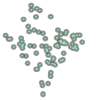

In [9]:
plants['geometry'] = plants.apply(lambda x: geodesic_point_buffer(x['Latitude'], x['Longitude'], 50), axis=1)
plant_states = set(plants['State'])
plant_shapes = cascaded_union(plants['geometry'])
plant_shapes

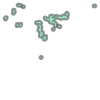

In [10]:
mines['geometry'] = mines.apply(lambda x: geodesic_point_buffer(x['Latitude'], x['Longitude'], 50), axis=1)
mine_states = set(mines['State']) - set(['Madhya Pradesh / Uttar Pradesh', 'Uttar Pradesh / Madhya Pradesh'])
mine_shapes = cascaded_union(mines['geometry'])
mine_shapes

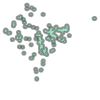

In [11]:
all_states = plant_states.union(mine_states)
all_shapes = cascaded_union(plants['geometry'].append(mines['geometry']))
all_shapes

## Plot inputs

In [12]:
os.chdir('../shapes')
transmission = gpd.read_file('transmission.shp')
# substations = cascaded_union(substations['geometry'])
transmission

polygons = {
    'plants': plant_shapes,
    'mines': mine_shapes,
}

<AxesSubplot:>

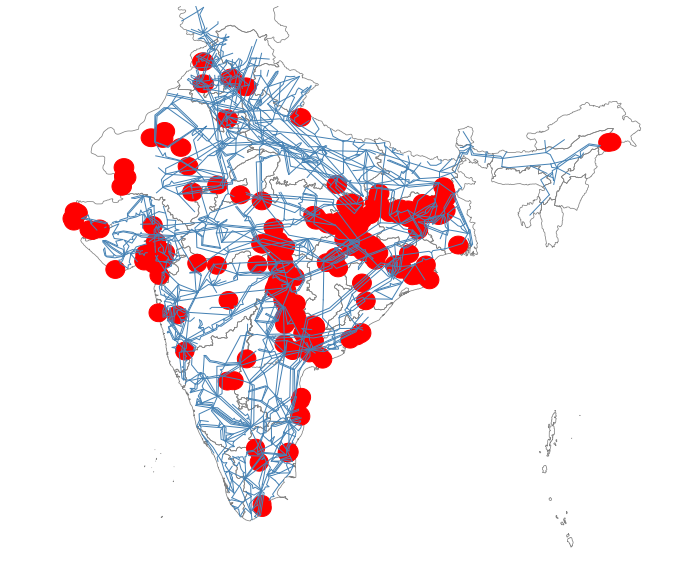

In [13]:
fig = geoplot.polyplot(
    gpd.GeoSeries(states),
    edgecolor='gray',
    figsize=(12, 12), 
    linewidth=0.75
)

geoplot.sankey(
    gpd.GeoSeries(transmission['geometry']),
    ax=fig
)

geoplot.polyplot(
    gpd.GeoSeries(polygons),
    edgecolor='red',
    facecolor='red',
    ax=fig
)

# Load Geodata MODIS Mask

In [14]:
os.chdir('../masks')

In [15]:
india_solar_coal = geodata.Mask("India Solar Coal", layer_path = {
    'modis': 'MODIS_INDIA_SOLAR.tif'
})

india_wind_coal = geodata.Mask("India Wind Coal", layer_path = {
    'modis': 'MODIS_INDIA_WIND.tif'
})

INFO:geodata.mask:Layer modis added to the mask India Solar Coal.
INFO:geodata.mask:Layer modis added to the mask India Wind Coal.


In [16]:
# india_wind_plants.layers['modis'] = geodata.mask.binarize_raster(india_wind_plants.layers['modis'], values = [6,7,8,9,10,12,14,16])
# india_wind_mines.layers['modis'] = geodata.mask.binarize_raster(india_wind_mines.layers['modis'], values = [6,7,8,9,10,12,14,16])
# india_wind_all.layers['modis'] = geodata.mask.binarize_raster(india_wind_all.layers['modis'], values = [6,7,8,9,10,12,14,16])

# india_solar_plants.layers['modis'] = geodata.mask.binarize_raster(india_solar_plants.layers['modis'], values = [6,7,8,9,10,16])
# india_solar_mines.layers['modis'] = geodata.mask.binarize_raster(india_solar_mines.layers['modis'], values = [6,7,8,9,10,16])
# india_solar_all.layers['modis'] = geodata.mask.binarize_raster(india_solar_all.layers['modis'], values = [6,7,8,9,10,16])

In [17]:
# geodata.mask.show_all(india_solar_plants.layers)

In [18]:
# geodata.mask.show_all(india_wind_plants.layers)

# Extract Shapes as Mask Layers

In [19]:
all_shapes = {'coal': all_shapes}

In [20]:
india_solar_coal.extract_shapes(all_shapes, layer = 'modis')
india_wind_coal.extract_shapes(all_shapes, layer = 'modis')

INFO:geodata.mask:Extracted shape coal added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape coal added to attribute 'shape_mask'.


In [21]:
india_solar_coal.add_shape_layer({
    'coal': all_shapes['coal']
}, reference_layer='modis')

india_wind_coal.add_shape_layer({
    'coal': all_shapes['coal']
}, reference_layer='modis')

INFO:geodata.mask:Layer coal added to the mask India Solar Coal.
INFO:geodata.mask:Layer coal added to the mask India Wind Coal.


# Merge Districts + MODIS

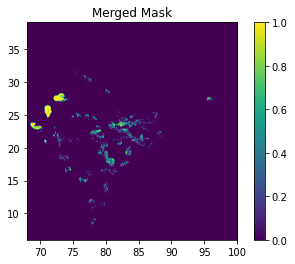

INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


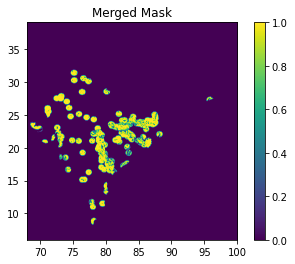

INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


In [22]:
india_solar_coal.merge_layer(attribute_save = True, layers = ['coal', 'modis'], method='and')
india_wind_coal.merge_layer(attribute_save = True, layers = ['coal', 'modis'], method='and')

## States 

In [23]:
india_solar_coal.extract_shapes({x: states[x] for x in all_states if x in states.keys()})
india_wind_coal.extract_shapes({x: states[x] for x in all_states if x in states.keys()})

INFO:geodata.mask:Extracted shape West Bengal added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Bihar added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Rajasthan added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Telangana added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Tamil Nadu added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Maharashtra added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Jharkhand added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Gujarat added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Karnataka added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Andhra Pradesh added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Odisha added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Uttar Pradesh added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Assam added to attribute 'shape_mask'

In [24]:
# geodata.mask.show_all(india_wind_all.shape_mask)

In [25]:
# geodata.mask.show_all(india_solar_all.shape_mask)

# Combine Mask with Cutout

In [26]:
india_solar_coal.save_mask()
india_wind_coal.save_mask()

INFO:geodata.mask:Mask India Solar Coal successfully saved at C:/Users/arjun/desktop/davidson_lab/data/masks
INFO:geodata.mask:Mask India Wind Coal successfully saved at C:/Users/arjun/desktop/davidson_lab/data/masks


In [27]:
cutout.add_mask("India Solar Coal", merged_mask=False, shape_mask=True)
cutout.add_grid_area()
combine_solar_coal = cutout.mask(dataset = xarray_ds_solar)

cutout.add_mask("India Wind Coal", merged_mask=False, shape_mask=True)
cutout.add_grid_area()
combine_wind_coal = cutout.mask(dataset = xarray_ds_wind)

INFO:geodata.mask:Layer ['coal', 'modis'] loaded to the mask India Solar Coal.
INFO:geodata.mask:Merged_mask loaded to the mask India Solar Coal.
INFO:geodata.mask:Shape mask ['Andhra Pradesh', 'Assam', 'Bihar', 'Chhattisgarh', 'coal', 'Gujarat', 'Haryana', 'Jharkhand', 'Karnataka', 'Madhya Pradesh', 'Maharashtra', 'Odisha', 'Rajasthan', 'Tamil Nadu', 'Telangana', 'Uttar Pradesh', 'West Bengal'] loaded to the mask India Solar Coal.
INFO:geodata.mask:Please close the shape_mask xarray(s) for further changes of the mask object.
INFO:geodata.cutout:Cutout.shape_mask added.
INFO:geodata.cutout:shape_mask combined with dataset. 
INFO:geodata.mask:Layer ['coal', 'modis'] loaded to the mask India Wind Coal.
INFO:geodata.mask:Merged_mask loaded to the mask India Wind Coal.
INFO:geodata.mask:Shape mask ['Andhra Pradesh', 'Assam', 'Bihar', 'Chhattisgarh', 'coal', 'Gujarat', 'Haryana', 'Jharkhand', 'Karnataka', 'Madhya Pradesh', 'Maharashtra', 'Odisha', 'Rajasthan', 'Tamil Nadu', 'Telangana', 'Ut

In [28]:
# export to pickle
filehandler = open("combine_solar_coal.pickle","wb")
pickle.dump(combine_solar_coal, filehandler)
filehandler.close()

filehandler = open("combine_wind_coal.pickle","wb")
pickle.dump(combine_wind_coal, filehandler)
filehandler.close()

# Plot CF Supply Curves

In [35]:
def make_figures(df, col, wacc=None):
    df = df[df[col] > 0]
    if col == 'wind':
        # deshmukh
        df['cap low'] = df['area'] * df['mask'] * 2.25 / 1000
        # Lu / NREL / Prof
        df['cap mid'] = df['area'] * df['mask'] * 3.9 / 1000
        # deshmukh
        df['cap high'] = df['area'] * df['mask'] * 9 / 1000
    else:
        # deshmukh
        df['cap low'] = df['area'] * df['mask'] * 7.5 / 1000
        # Lu / NREL / Prof
        df['cap mid'] = df['area'] * df['mask'] * 27.7 / 1000
        # deshmukh
        df['cap high'] = df['area'] * df['mask'] * 30 / 1000
    if wacc != None:
        df = df.sort_values(by = 'LCOE ($/MWh) {}'.format(wacc), ascending = True)
    else:
        df = df.sort_values(by = col, ascending = False)
    df = df[df['cap low'] > 0]
    df = df[df['cap mid'] > 0]
    df = df[df['cap high'] > 0]
    df['cumsum low'] = df['cap low'].cumsum()
    df['cumsum mid'] = df['cap mid'].cumsum()
    df['cumsum high'] = df['cap high'].cumsum()
    return df.reset_index(drop=True)

def batch_figures(xr_provs, t_30, t_47, legend, col='solar', coal='Plants+Mines', wacc=None, grid=False):
    dfs = {xr_prov:[] for xr_prov in xr_provs}
    for xr_prov in xr_provs:
        if xr_prov != 'coal':
            df = xr_provs[xr_prov].to_dataframe().reset_index(drop=False)
            df = make_figures(df, col, wacc)
            dfs[xr_prov] = df
    fig = go.Figure()
    if wacc != None:
        for xr_prov in xr_provs:
            if xr_prov != 'coal':
                fig.add_trace(
                    go.Scatter(
                        x=dfs[xr_prov]['cumsum mid'],
                        y=dfs[xr_prov]['LCOE ($/MWh) {}'.format(wacc)],
                        mode='lines', 
                        line=go.scatter.Line(color=legend[xr_prov]),
                        name=xr_prov,
                        showlegend=True
                    )
                )
        fig.update_layout(
            title="{} LCOE Supply Curves within 50km of Coal {} in India".format(col.capitalize(), coal),
            xaxis_title="Cumulative Capacity (GW)",
            yaxis_title="LCOE ($/MWh)",
            legend_title="Provinces",
        )
    else:
        for xr_prov in xr_provs:
            if xr_prov != 'coal':
                fig.add_trace(
                    go.Scatter(
                        x=dfs[xr_prov]['cumsum mid'],
                        y=dfs[xr_prov][col],
                        mode='lines', 
                        line=go.scatter.Line(color=legend[xr_prov]),
                        name=xr_prov,
                        showlegend=True
                    )
                )      
        fig.update_layout(
            title="{} Capacity Supply Curves within 50km of Coal {} in India".format(col.capitalize(), coal),
            xaxis_title="Cumulative Capacity (GW)",
            yaxis_title="Capacity Factor (%)",
            legend_title="Provinces",
        )
    fig.add_vline(
        x=sum(t_30.values()),
        annotation_text="Target 2030: {} GW".format(round(sum(t_30.values()), 2)),
        annotation_position='bottom right',
        line_dash="dash"
    )
    fig.add_vline(
        x=sum(t_47.values()),
        annotation_text="Target 2047: {} GW".format(round(sum(t_47.values()), 2)),
        annotation_position='bottom right',
        line_dash="dash"
    )
        
    fig.show()
    if wacc != None:
        if grid:
            fig.write_image("grid_{}_coal_lcoe_supplies.png".format(col))
        else:
            fig.write_image("{}_coal_lcoe_supplies.png".format(col))
    else:
        if grid:
            fig.write_image("grid_{}_coal_cf_supplies.png".format(col))
        else:
            fig.write_image("{}_coal_cf_supplies.png".format(col))

    return dfs

In [36]:
os.chdir('../../outputs/plots')

## Capacity Supply Curves

### Solar

In [37]:
solar_coal_dfs = batch_figures(combine_solar_coal, solar_t_30, solar_t_47, state_legend, col='solar')

### Wind

In [38]:
wind_coal_dfs = batch_figures(combine_wind_coal, wind_t_30, wind_t_47, state_legend, col='wind')

## LCOE Supply Curves

### Solar

In [39]:
solar_coal_dfs_lcoe = batch_figures(combine_solar_coal, solar_t_30, solar_t_47, state_legend, col='solar', wacc='high')

### Wind

In [40]:
wind_coal_dfs_lcoe = batch_figures(combine_wind_coal, wind_t_30, wind_t_47, state_legend, col='wind', wacc='high')

# Plot Figures by State

In [44]:
def plot_fig_state(dfs, state, t_30, t_47, col='solar', pf='mid', wacc=None, show=False):
    df = dfs[state]
    avg_30 = np.nan
    avg_47 = np.nan
    if len(df) > 0:
        if df['cumsum {}'.format(pf)].values[0] > t_30[state]:
            df_30 = df.head(1)
        if df['cumsum {}'.format(pf)].values[0] > t_47[state]:
            df_47 = df.head(1)
        if (df['cumsum {}'.format(pf)].values[0] > t_30[state]) and (df['cumsum {}'.format(pf)].values[0] < t_47[state]):
            df_47 = df[df['cumsum {}'.format(pf)] <= t_47[state]]
        if (df['cumsum {}'.format(pf)].values[0] < t_30[state]) and (df['cumsum {}'.format(pf)].values[0] < t_47[state]):
            df_30 = df[df['cumsum {}'.format(pf)] <= t_30[state]]
            df_47 = df[df['cumsum {}'.format(pf)] <= t_47[state]]
    else:
        return avg_30, avg_47
    
    if sum(df_30['cap {}'.format(pf)]) > 0 and sum(df_47['cap {}'.format(pf)]) > 0:
        if wacc != None: 
            avg_30 = round(sum(df_30['cap {}'.format(pf)] * df_30['LCOE ($/MWh) {}'.format(wacc)]) / sum(df_30['cap {}'.format(pf)]), 2)        
            avg_47 = round(sum(df_47['cap {}'.format(pf)] * df_47['LCOE ($/MWh) {}'.format(wacc)]) / sum(df_47['cap {}'.format(pf)]), 2)
        else:
            avg_30 = round(sum(df_30['cap {}'.format(pf)] * df_30[col]) / sum(df_30['cap {}'.format(pf)]), 2)        
            avg_47 = round(sum(df_47['cap {}'.format(pf)] * df_47[col]) / sum(df_47['cap {}'.format(pf)]), 2)

    if show:
        fig = go.Figure() 
        if t_30[state] > 0 and t_47[state] > 0:
            fig.add_vline(
                x=t_30[state],
                annotation_text="Target 2030: {} GW".format(round(t_30[state], 2)),
                annotation_position='bottom right',
                line_dash="dash"
            )
            fig.add_vline(
                x=t_47[state],
                annotation_text="Target 2047: {} GW".format(round(t_47[state], 2)),
                annotation_position='bottom right',
                line_dash="dash"
            )
            if len(dfs[state]['cumsum {}'.format(pf)]) > 0:
                fig.update_xaxes(
                    range=(dfs[state]['cumsum {}'.format(pf)][0], 55)
                )
        if wacc != None:
            fig.add_trace(
                go.Scatter(
                    x=dfs[state]['cumsum {}'.format(pf)],
                    y=dfs[state]['LCOE ($/MWh) {}'.format(wacc)],
                    name='Restricted Case'
                )
            )
            fig.add_hline(
                y=avg_30,
                annotation_text="Mean LCOE 2030: {} $/MWh".format(avg_30),
                annotation_position='bottom left',
                line_dash="dash"
            )
            fig.add_hline(
                y=avg_47,
                annotation_text="Mean LCOE 2047: {} $/MWh".format(avg_47),
                annotation_position='top left',
                line_dash="dash"
            )
            fig.update_layout(
                title="{} LCOE Supply Curves in Provinces with Coal Plants+Mines in {}".format(col.capitalize(), 
                                                                                               state),
                xaxis_title="Cumulative Capacity (GW)",
                yaxis_title="LCOE ($/MWh)",
                legend_title="Province",
            )
            if col == 'wind':
                fig.update_yaxes(
                    range=(40, 80)
                )
        else:
            fig.add_trace(
                go.Scatter(
                    x=dfs[state]['cumsum {}'.format(pf)],
                    y=dfs[state][col], 
                    name='Restricted Case'
                )
            )
            fig.add_hline(
                y=avg_30,
                annotation_text="Mean CF 2030: {}".format(avg_30),
                annotation_position='top left',
                line_dash="dash"
            )
            fig.add_hline(
                y=avg_47,
                annotation_text="Mean CF 2047: {}".format(avg_47),
                annotation_position='bottom left',
                line_dash="dash"
            )
            fig.update_layout(
                title="{} Capacity Supply Curves in Provinces with Coal Plants+Mines in {}".format(col.capitalize(), 
                                                                                                   state),
                xaxis_title="Cumulative Capacity (GW)",
                yaxis_title="Capacity Factor (%)",
                legend_title="Province",
            )

        fig.show()
    return avg_30, avg_47

# Get State Averages

In [45]:
averages_solar_2030 = {state: [] for state in states if solar_t_30[state] > 0}
averages_solar_2050 = {state: [] for state in states if solar_t_47[state] > 0}
averages_wind_2030 = {state: [] for state in states if wind_t_30[state] > 0}
averages_wind_2050 = {state: [] for state in states if wind_t_47[state] > 0}

for state in states:
    if state in all_states:        
        solar_high_pf_avg_CF = plot_fig_state(solar_coal_dfs,  state, solar_t_30, solar_t_47, 
                                              col='solar', pf='high')
        solar_mid_pf_avg_CF = plot_fig_state(solar_coal_dfs,  state, solar_t_30, solar_t_47, 
                                              col='solar', pf='mid')
        solar_low_pf_avg_CF = plot_fig_state(solar_coal_dfs,  state, solar_t_30, solar_t_47, 
                                              col='solar', pf='low')
        solar_high_pf_high_wacc_avg_LCOE = plot_fig_state(solar_coal_dfs_lcoe, state, solar_t_30, solar_t_47, 
                                                          col='solar', pf='high', wacc='high')
        solar_mid_pf_high_wacc_avg_LCOE = plot_fig_state(solar_coal_dfs_lcoe, state, solar_t_30, solar_t_47, 
                                                          col='solar', pf='mid', wacc='high')
        solar_low_pf_high_wacc_avg_LCOE = plot_fig_state(solar_coal_dfs_lcoe, state, solar_t_30, solar_t_47, 
                                                          col='solar', pf='low', wacc='high')
        solar_high_pf_mid_wacc_avg_LCOE = plot_fig_state(solar_coal_dfs_lcoe, state, solar_t_30, solar_t_47, 
                                                  col='solar', pf='high', wacc='mid')
        solar_mid_pf_mid_wacc_avg_LCOE = plot_fig_state(solar_coal_dfs_lcoe, state, solar_t_30, solar_t_47, 
                                                  col='solar', pf='mid', wacc='mid')
        solar_low_pf_mid_wacc_avg_LCOE = plot_fig_state(solar_coal_dfs_lcoe, state, solar_t_30, solar_t_47, 
                                                  col='solar', pf='low', wacc='mid')
        solar_high_pf_low_wacc_avg_LCOE = plot_fig_state(solar_coal_dfs_lcoe, state, solar_t_30, solar_t_47, 
                                                          col='solar', pf='high', wacc='low')
        solar_mid_pf_low_wacc_avg_LCOE = plot_fig_state(solar_coal_dfs_lcoe, state, solar_t_30, solar_t_47, 
                                                          col='solar', pf='mid', wacc='low')
        solar_low_pf_low_wacc_avg_LCOE = plot_fig_state(solar_coal_dfs_lcoe, state, solar_t_30, solar_t_47, 
                                                          col='solar', pf='low', wacc='low')

        wind_high_pf_avg_CF = plot_fig_state(wind_coal_dfs,  state, wind_t_30, wind_t_47, 
                                              col='wind', pf='high')
        wind_mid_pf_avg_CF = plot_fig_state(wind_coal_dfs,  state, wind_t_30, wind_t_47, 
                                              col='wind', pf='mid')
        wind_low_pf_avg_CF = plot_fig_state(wind_coal_dfs,  state, wind_t_30, wind_t_47, 
                                              col='wind', pf='low')
        wind_high_pf_high_wacc_avg_LCOE = plot_fig_state(wind_coal_dfs_lcoe, state, wind_t_30, wind_t_47, 
                                                          col='wind', pf='high', wacc='high')
        wind_mid_pf_high_wacc_avg_LCOE = plot_fig_state(wind_coal_dfs_lcoe, state, wind_t_30, wind_t_47, 
                                                          col='wind', pf='mid', wacc='high')
        wind_low_pf_high_wacc_avg_LCOE = plot_fig_state(wind_coal_dfs_lcoe, state, wind_t_30, wind_t_47, 
                                                          col='wind', pf='low', wacc='high')
        wind_high_pf_mid_wacc_avg_LCOE = plot_fig_state(wind_coal_dfs_lcoe, state, wind_t_30, wind_t_47, 
                                                  col='wind', pf='high', wacc='mid')
        wind_mid_pf_mid_wacc_avg_LCOE = plot_fig_state(wind_coal_dfs_lcoe, state, wind_t_30, wind_t_47, 
                                                  col='wind', pf='mid', wacc='mid')
        wind_low_pf_mid_wacc_avg_LCOE = plot_fig_state(wind_coal_dfs_lcoe, state, wind_t_30, wind_t_47, 
                                                  col='wind', pf='low', wacc='mid')
        wind_high_pf_low_wacc_avg_LCOE = plot_fig_state(wind_coal_dfs_lcoe, state, wind_t_30, wind_t_47, 
                                                          col='wind', pf='high', wacc='low')
        wind_mid_pf_low_wacc_avg_LCOE = plot_fig_state(wind_coal_dfs_lcoe, state, wind_t_30, wind_t_47, 
                                                          col='wind', pf='mid', wacc='low')
        wind_low_pf_low_wacc_avg_LCOE = plot_fig_state(wind_coal_dfs_lcoe, state, wind_t_30, wind_t_47, 
                                                          col='wind', pf='low', wacc='low')

    if solar_t_30[state] > 0: 
        averages_solar_2030[state] = [
            solar_high_pf_avg_CF[0], solar_mid_pf_avg_CF[0], solar_low_pf_avg_CF[0],
            solar_high_pf_high_wacc_avg_LCOE[0], solar_mid_pf_high_wacc_avg_LCOE[0], solar_low_pf_high_wacc_avg_LCOE[0],
            solar_high_pf_mid_wacc_avg_LCOE[0], solar_mid_pf_mid_wacc_avg_LCOE[0], solar_low_pf_mid_wacc_avg_LCOE[0],
            solar_high_pf_low_wacc_avg_LCOE[0], solar_mid_pf_low_wacc_avg_LCOE[0], solar_low_pf_low_wacc_avg_LCOE[0]
        ]
    
    if solar_t_47[state] > 0: 
        averages_solar_2050[state] = [
            solar_high_pf_avg_CF[1], solar_mid_pf_avg_CF[1], solar_low_pf_avg_CF[1],
            solar_high_pf_high_wacc_avg_LCOE[1], solar_mid_pf_high_wacc_avg_LCOE[1], solar_low_pf_high_wacc_avg_LCOE[1],
            solar_high_pf_mid_wacc_avg_LCOE[1], solar_mid_pf_mid_wacc_avg_LCOE[1], solar_low_pf_mid_wacc_avg_LCOE[1],
            solar_high_pf_low_wacc_avg_LCOE[1], solar_mid_pf_low_wacc_avg_LCOE[1], solar_low_pf_low_wacc_avg_LCOE[1]
        ]
        
    if wind_t_30[state] > 0: 
        averages_wind_2030[state] = [
            wind_high_pf_avg_CF[0], wind_mid_pf_avg_CF[0], wind_low_pf_avg_CF[0],
            wind_high_pf_high_wacc_avg_LCOE[0], wind_mid_pf_high_wacc_avg_LCOE[0], wind_low_pf_high_wacc_avg_LCOE[0],
            wind_high_pf_mid_wacc_avg_LCOE[0], wind_mid_pf_mid_wacc_avg_LCOE[0], wind_low_pf_mid_wacc_avg_LCOE[0],
            wind_high_pf_low_wacc_avg_LCOE[0], wind_mid_pf_low_wacc_avg_LCOE[0], wind_low_pf_low_wacc_avg_LCOE[0]
        ]
    
    if wind_t_47[state] > 0: 
        averages_wind_2050[state] = [
            wind_high_pf_avg_CF[1], wind_mid_pf_avg_CF[1], wind_low_pf_avg_CF[1],
            wind_high_pf_high_wacc_avg_LCOE[1], wind_mid_pf_high_wacc_avg_LCOE[1], wind_low_pf_high_wacc_avg_LCOE[1],
            wind_high_pf_mid_wacc_avg_LCOE[1], wind_mid_pf_mid_wacc_avg_LCOE[1], wind_low_pf_mid_wacc_avg_LCOE[1],
            wind_high_pf_low_wacc_avg_LCOE[1], wind_mid_pf_low_wacc_avg_LCOE[1], wind_low_pf_low_wacc_avg_LCOE[1]
        ]

In [46]:
# make pivot tables
pivot_solar_2030 = pd.DataFrame(averages_solar_2030).T
pivot_solar_2030.columns = [
    'solar_high_pf_avg_CF', 'solar_mid_pf_avg_CF', 'solar_low_pf_avg_CF',
    'solar_high_pf_high_wacc_avg_LCOE', 'solar_high_pf_mid_wacc_avg_LCOE', 'solar_high_pf_low_wacc_avg_LCOE',
    'solar_mid_pf_high_wacc_avg_LCOE', 'solar_mid_pf_mid_wacc_avg_LCOE', 'solar_mid_pf_low_wacc_avg_LCOE',
    'solar_low_pf_high_wacc_avg_LCOE', 'solar_low_pf_mid_wacc_avg_LCOE', 'solar_low_pf_low_wacc_avg_LCOE'
]

pivot_solar_2050 = pd.DataFrame(averages_solar_2050).T
pivot_solar_2050.columns = [
    'solar_high_pf_avg_CF', 'solar_mid_pf_avg_CF', 'solar_low_pf_avg_CF',
    'solar_high_pf_high_wacc_avg_LCOE', 'solar_high_pf_mid_wacc_avg_LCOE', 'solar_high_pf_low_wacc_avg_LCOE',
    'solar_mid_pf_high_wacc_avg_LCOE', 'solar_mid_pf_mid_wacc_avg_LCOE', 'solar_mid_pf_low_wacc_avg_LCOE',
    'solar_low_pf_high_wacc_avg_LCOE', 'solar_low_pf_mid_wacc_avg_LCOE', 'solar_low_pf_low_wacc_avg_LCOE'
]

# make pivot tables
pivot_wind_2030 = pd.DataFrame(averages_wind_2030).T
pivot_wind_2030.columns = [
    'wind_high_pf_avg_CF', 'wind_mid_pf_avg_CF', 'wind_low_pf_avg_CF',
    'wind_high_pf_high_wacc_avg_LCOE', 'wind_high_pf_mid_wacc_avg_LCOE', 'wind_high_pf_low_wacc_avg_LCOE',
    'wind_mid_pf_high_wacc_avg_LCOE', 'wind_mid_pf_mid_wacc_avg_LCOE', 'wind_mid_pf_low_wacc_avg_LCOE',
    'wind_low_pf_high_wacc_avg_LCOE', 'wind_low_pf_mid_wacc_avg_LCOE', 'wind_low_pf_low_wacc_avg_LCOE'
]

pivot_wind_2050 = pd.DataFrame(averages_wind_2050).T
pivot_wind_2050.columns = [
    'wind_high_pf_avg_CF', 'wind_mid_pf_avg_CF', 'wind_low_pf_avg_CF',
    'wind_high_pf_high_wacc_avg_LCOE', 'wind_high_pf_mid_wacc_avg_LCOE', 'wind_high_pf_low_wacc_avg_LCOE',
    'wind_mid_pf_high_wacc_avg_LCOE', 'wind_mid_pf_mid_wacc_avg_LCOE', 'wind_mid_pf_low_wacc_avg_LCOE',
    'wind_low_pf_high_wacc_avg_LCOE', 'wind_low_pf_mid_wacc_avg_LCOE', 'wind_low_pf_low_wacc_avg_LCOE'
]

In [47]:
# # break down into smaller dataframes
solar_cf_coal_summary_30 = pivot_solar_2030[['solar_high_pf_avg_CF', 'solar_mid_pf_avg_CF', 'solar_low_pf_avg_CF']]
solar_cf_coal_summary_30.columns = ['High PF', 'Medium PF', 'Low PF']

solar_lcoe_coal_summary_30 = pivot_solar_2030[[
    'solar_high_pf_high_wacc_avg_LCOE', 'solar_high_pf_mid_wacc_avg_LCOE', 'solar_high_pf_low_wacc_avg_LCOE',
    'solar_mid_pf_high_wacc_avg_LCOE', 'solar_mid_pf_mid_wacc_avg_LCOE', 'solar_mid_pf_low_wacc_avg_LCOE',
    'solar_low_pf_high_wacc_avg_LCOE', 'solar_low_pf_mid_wacc_avg_LCOE', 'solar_low_pf_low_wacc_avg_LCOE'
]]
solar_lcoe_coal_summary_30.columns = ['High WACC High PF', 'Medium WACC High PF', 'Low WACC High PF',
                                 'High WACC Medium PF', 'Medium WACC Medium PF', 'Low WACC Medium PF',
                                 'High WACC Low PF', 'Medium WACC Low PF', 'Low WACC Low PF']

wind_cf_coal_summary_30 = pivot_wind_2030[['wind_high_pf_avg_CF', 'wind_mid_pf_avg_CF', 'wind_low_pf_avg_CF']]
wind_cf_coal_summary_30.columns = ['High PF', 'Medium PF', 'Low PF']

wind_lcoe_coal_summary_30 = pivot_wind_2030[[
    'wind_high_pf_high_wacc_avg_LCOE', 'wind_high_pf_mid_wacc_avg_LCOE', 'wind_high_pf_low_wacc_avg_LCOE',
    'wind_mid_pf_high_wacc_avg_LCOE', 'wind_mid_pf_mid_wacc_avg_LCOE', 'wind_mid_pf_low_wacc_avg_LCOE',
    'wind_low_pf_high_wacc_avg_LCOE', 'wind_low_pf_mid_wacc_avg_LCOE', 'wind_low_pf_low_wacc_avg_LCOE'
]]
wind_lcoe_coal_summary_30.columns = ['High WACC High PF', 'Medium WACC High PF', 'Low WACC High PF',
                                'High WACC Medium PF', 'Medium WACC Medium PF', 'Low WACC Medium PF',
                                'High WACC Low PF', 'Medium WACC Low PF', 'Low WACC Low PF']

solar_cf_coal_summary_50 = pivot_solar_2050[['solar_high_pf_avg_CF', 'solar_mid_pf_avg_CF', 'solar_low_pf_avg_CF']]
solar_cf_coal_summary_50.columns = ['High PF', 'Medium PF', 'Low PF']

solar_lcoe_coal_summary_50 = pivot_solar_2050[[
    'solar_high_pf_high_wacc_avg_LCOE', 'solar_high_pf_mid_wacc_avg_LCOE', 'solar_high_pf_low_wacc_avg_LCOE',
    'solar_mid_pf_high_wacc_avg_LCOE', 'solar_mid_pf_mid_wacc_avg_LCOE', 'solar_mid_pf_low_wacc_avg_LCOE',
    'solar_low_pf_high_wacc_avg_LCOE', 'solar_low_pf_mid_wacc_avg_LCOE', 'solar_low_pf_low_wacc_avg_LCOE'
]]
solar_lcoe_coal_summary_50.columns = ['High WACC High PF', 'Medium WACC High PF', 'Low WACC High PF',
                                 'High WACC Medium PF', 'Medium WACC Medium PF', 'Low WACC Medium PF',
                                 'High WACC Low PF', 'Medium WACC Low PF', 'Low WACC Low PF']

wind_cf_coal_summary_50 = pivot_wind_2050[['wind_high_pf_avg_CF', 'wind_mid_pf_avg_CF', 'wind_low_pf_avg_CF']]
wind_cf_coal_summary_50.columns = ['High PF', 'Medium PF', 'Low PF']

wind_lcoe_coal_summary_50 = pivot_wind_2050[[
    'wind_high_pf_high_wacc_avg_LCOE', 'wind_high_pf_mid_wacc_avg_LCOE', 'wind_high_pf_low_wacc_avg_LCOE',
    'wind_mid_pf_high_wacc_avg_LCOE', 'wind_mid_pf_mid_wacc_avg_LCOE', 'wind_mid_pf_low_wacc_avg_LCOE',
    'wind_low_pf_high_wacc_avg_LCOE', 'wind_low_pf_mid_wacc_avg_LCOE', 'wind_low_pf_low_wacc_avg_LCOE'
]]
wind_lcoe_coal_summary_50.columns = ['High WACC High PF', 'Medium WACC High PF', 'Low WACC High PF',
                                'High WACC Medium PF', 'Medium WACC Medium PF', 'Low WACC Medium PF',
                                'High WACC Low PF', 'Medium WACC Low PF', 'Low WACC Low PF']

In [48]:
os.chdir('../tables')

In [49]:
# export to pickle
filehandler = open("solar_cf_coal_summary_30.pickle","wb")
pickle.dump(solar_cf_coal_summary_30, filehandler)
filehandler.close()
filehandler = open("solar_lcoe_coal_summary_30.pickle","wb")
pickle.dump(solar_lcoe_coal_summary_30, filehandler)
filehandler.close()
filehandler = open("wind_cf_coal_summary_30.pickle","wb")
pickle.dump(wind_cf_coal_summary_30, filehandler)
filehandler.close()
filehandler = open("wind_lcoe_coal_summary_30.pickle","wb")
pickle.dump(wind_lcoe_coal_summary_30, filehandler)
filehandler.close()

filehandler = open("solar_cf_coal_summary_50.pickle","wb")
pickle.dump(solar_cf_coal_summary_50, filehandler)
filehandler.close()
filehandler = open("solar_lcoe_coal_summary_50.pickle","wb")
pickle.dump(solar_lcoe_coal_summary_50, filehandler)
filehandler.close()
filehandler = open("wind_cf_coal_summary_50.pickle","wb")
pickle.dump(wind_cf_coal_summary_50, filehandler)
filehandler.close()
filehandler = open("wind_lcoe_coal_summary_50.pickle","wb")
pickle.dump(wind_lcoe_coal_summary_50, filehandler)
filehandler.close()